<a href="https://colab.research.google.com/github/sandeep92134/PYTHON-Data-Cleaning/blob/master/chapter%204/Exersize%202.%20Identifying%20outliers%20with%20one%20variable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqline
import scipy.stats as scistat
pd.set_option('display.width', 85)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.0f}'.format
covidtotals = pd.read_csv("https://raw.githubusercontent.com/sandeep92134/PYTHON-Data-Cleaning/master/Chapter%204/datasets/covidtotals.csv")
covidtotals.set_index("iso_code", inplace=True)

# set up the cumulative and demographic columns
totvars = ['location','total_cases','total_deaths','total_cases_pm',
  'total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita',
  'hosp_beds']

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# get descriptive statistics on the cumulative values
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,210,210,210,210
mean,"29,216","1,771","1,355",56
std,"136,398","8,706","2,625",145
min,0,0,0,0
25%,176,4,93,1
50%,"1,242",26,281,6
75%,"10,117",241,"1,801",32
max,"1,790,191","104,383","19,771","1,238"


In [3]:
pd.options.display.float_format = '{:,.2f}'.format
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.00,0.00,0.00,0.00,0.00
0.10,22.90,0.00,18.00,0.00
0.20,105.20,2.00,56.29,0.38
0.30,302.00,6.70,115.43,1.72
0.40,762.00,12.00,213.97,3.96
0.50,"1,242.50",25.50,280.93,6.15
0.60,"2,514.60",54.60,543.96,12.25
0.70,"6,959.80",137.20,"1,071.24",25.95
0.80,"16,847.20",323.20,"2,206.30",49.97
0.90,"46,513.10","1,616.90","3,765.14",138.90


In [4]:
covidtotalsonly.skew()

total_cases       10.80
total_deaths       8.93
total_cases_pm     4.40
total_deaths_pm    4.67
dtype: float64

In [5]:
covidtotalsonly.kurtosis()

total_cases       134.98
total_deaths       95.74
total_cases_pm     25.24
total_deaths_pm    27.24
dtype: float64

In [6]:
# test for normality
def testnorm(var, df):
  stat, p = scistat.shapiro(df[var])
  return p

In [7]:
testnorm("total_cases", covidtotalsonly)

3.753789128593843e-29

In [8]:
testnorm("total_deaths", covidtotalsonly)

4.3427896631016077e-29

In [9]:
testnorm("total_cases_pm", covidtotalsonly)

1.3972683006509067e-23

In [10]:
testnorm("total_deaths_pm", covidtotalsonly)

1.361060423265974e-25

Text(0.5, 1.0, 'QQ Plot of Total Cases')

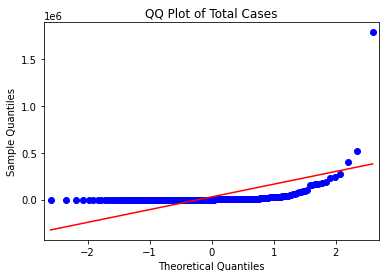

In [11]:
# show a qqplot for total cases and total cases per million
sm.qqplot(covidtotalsonly[['total_cases']]. \
  sort_values(['total_cases']), line='s')
plt.title("QQ Plot of Total Cases")

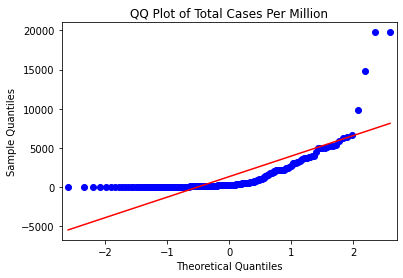

In [12]:
sm.qqplot(covidtotals[['total_cases_pm']]. \
  sort_values(['total_cases_pm']), line='s')
plt.title("QQ Plot of Total Cases Per Million")
plt.show()

In [13]:
# show outliers for total cases
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5*(thirdq-firstq)
outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange
print(outlierlow, outlierhigh, sep=" <--> ")

-14736.125 <--> 25028.875


In [14]:
# generate a table of outliers and save it to Excel
def getoutliers():
  dfout = pd.DataFrame(columns=covidtotals.columns, data=None)
  for col in covidtotalsonly.columns[1:]:
    thirdq, firstq = covidtotalsonly[col].quantile(0.75),\
      covidtotalsonly[col].quantile(0.25)
    interquartilerange = 1.5*(thirdq-firstq)
    outlierhigh, outlierlow = interquartilerange+thirdq,\
      firstq-interquartilerange
    df = covidtotals.loc[(covidtotals[col]>outlierhigh) | \
      (covidtotals[col]<outlierlow)]
    df = df.assign(varname = col, threshlow = outlierlow,\
       threshhigh = outlierhigh)
    dfout = pd.concat([dfout, df])
  return dfout

outliers = getoutliers()
outliers.varname.value_counts()

total_deaths       36
total_cases        33
total_deaths_pm    28
total_cases_pm     17
Name: varname, dtype: int64

In [15]:
outliers.to_excel("/content/outlierscases.xlsx")

In [16]:
# look a little more closely at outliers for cases per million
outliers.loc[outliers.varname=="total_cases_pm",\
  ['location','total_cases_pm','pop_density','gdp_per_capita']].\
  sort_values(['total_cases_pm'], ascending=False)

,location,total_cases_pm,pop_density,gdp_per_capita
SMR,San Marino,"19,771.35",556.67,"56,861.47"
QAT,Qatar,"19,753.15",227.32,"116,935.60"
VAT,Vatican,"14,833.13",nan,nan
AND,Andorra,"9,888.05",163.75,nan
BHR,Bahrain,"6,698.47","1,935.91","43,290.71"
LUX,Luxembourg,"6,418.78",231.45,"94,277.96"
KWT,Kuwait,"6,332.42",232.13,"65,530.54"
SGP,Singapore,"5,962.73","7,915.73","85,535.38"
USA,United States,"5,408.39",35.61,"54,225.45"
ISL,Iceland,"5,292.31",3.40,"46,482.96"


In [17]:
covidtotals[['pop_density','gdp_per_capita']].quantile([0.25,0.5,0.75])

,pop_density,gdp_per_capita
0.25,37.42,"4,485.33"
0.50,87.25,"13,183.08"
0.75,214.12,"28,556.53"


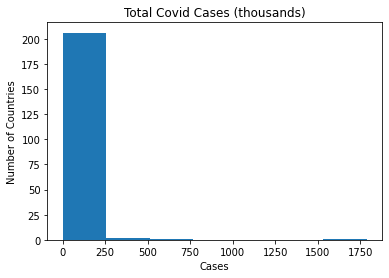

In [18]:
# show the total cases histogram again
plt.hist(covidtotalsonly['total_cases']/1000, bins=7)
plt.title("Total Covid Cases (thousands)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()

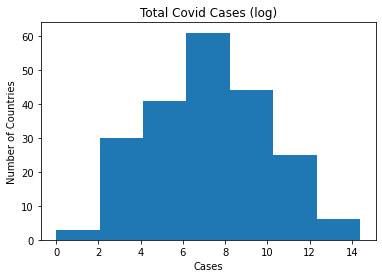

In [19]:
# do a log transformation of the covid data
covidlogs = covidtotalsonly.copy()
for col in covidtotalsonly.columns[1:]:
  covidlogs[col] = np.log1p(covidlogs[col])

plt.hist(covidlogs['total_cases'], bins=7)
plt.title("Total Covid Cases (log)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()